# Plot temperature response over time

## Imports:

In [1]:
import xarray as xr
from IPython.display import clear_output
import numpy as np
import os
import re
from pathlib import Path
import pandas as pd
import tqdm
from scmdata import df_append, ScmDataFrame
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
from ar6_ch6_rcmipfigs.constants import BASE_DIR
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, INPUT_DATA_DIR, RESULTS_DIR

#PATH_DATASET = OUTPUT_DATA_DIR + '/forcing_data_rcmip_models.nc'
PATH_DT = OUTPUT_DATA_DIR + '/dT_data_rcmip_models.nc'

/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs
/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in


## Set values:

In [3]:
first_y ='1850'
last_y = '2100'

**Set reference year for temperature change:**

In [4]:
ref_year = '2021'

In [5]:
FIGURE_DIR = RESULTS_DIR + '/figures/'

In [6]:

climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'

### Define variables to look at:

In [7]:
# variables to plot:
variables_erf_comp = [
    'Effective Radiative Forcing|Anthropogenic|CH4',
    'Effective Radiative Forcing|Anthropogenic|Aerosols',
    'Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone',
    'Effective Radiative Forcing|Anthropogenic|F-Gases|HFC',
    'Effective Radiative Forcing|Anthropogenic|Other|BC on Snow']
# total ERFs for anthropogenic and total:
variables_erf_tot = ['Effective Radiative Forcing|Anthropogenic',
                     'Effective Radiative Forcing']
# Scenarios to plot:
scenarios_fl = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF-aerchemmip',  # 'ssp370-lowNTCF', Due to mistake here
                'ssp585', 'historical']

scenarios_fl_370 = ['ssp370', 'ssp370-lowNTCF-aerchemmip','ssp370-lowNTCF-gidden'# Due to mistake here
                ]

climatemodels_fl = ['Cicero-SCM', 'Cicero-SCM-ECS3', 'FaIR-1.5-DEFAULT', 'MAGICC7.1.0.beta-rcmip-phase-1', 'OSCARv3.0']

### Scenarios:

In [8]:
scenarios_fl=['ssp119',
              'ssp126',
              'ssp245',
              'ssp370',
              'ssp370-lowNTCF-aerchemmip',
              #'ssp370-lowNTCF-gidden',
              'ssp585']

## Open dataset:

### Integrate:
The code below opens the file generated in [2_compute_delta_T.ipynb](2_compute_delta_T.ipynb) by integrating

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

where IRF is the impulse response function and ERF is the effective radiative forcing from RCMIP. 

In [9]:
ds_DT = xr.open_dataset(PATH_DT)

In [10]:
ds_DT#.climatemodel

<xarray.Dataset>
Dimensions:                                                       (climatemodel: 5, scenario: 8, time: 251)
Coordinates:
  * time                                                          (time) datetime64[ns] 1850-01-01 ... 2100-01-01
    model                                                         object ...
  * scenario                                                      (scenario) object 'historical' ... 'ssp585'
    region                                                        object ...
    unit                                                          object ...
  * climatemodel                                                  (climatemodel) object 'Cicero-SCM' ... 'OSCARv3.0'
    unit_context                                                  object ...
Data variables:
    Effective Radiative Forcing                                   (scenario, climatemodel, time) float64 ...
    Effective Radiative Forcing|Anthropogenic                     (scenario, climatemodel, time) float64 ...
    Effective Radiative Forcing|Anthropogenic|Other|BC on Snow    (scenario, climatemodel, time) float64 ...
    Effective Radiative Forcing|Anthropogenic|F-Gases|HFC         (scenario, climatemodel, time) float64 ...
    Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone  (scenario, climatemodel, time) float64 ...
    Effective Radiative Forcing|Anthropogenic|Aerosols            (scenario, climatemodel, time) float64 ...
    Effective Radiative Forcing|Anthropogenic|CH4                 (scenario, climatemodel, time) float64 ...
    year                                                          (time) int64 ...
    month                                                         (time) int64 ...
    day                                                           (time) int64 ...
    delta_t                                                       (time) float64 ...
    Delta T|Anthropogenic|CH4                                     (scenario, climatemodel, time) float64 ...
    Delta T|Anthropogenic|Aerosols                                (scenario, climatemodel, time) float64 ...
    Delta T|Anthropogenic|Tropospheric Ozone                      (scenario, climatemodel, time) float64 ...
    Delta T|Anthropogenic|F-Gases|HFC                             (scenario, climatemodel, time) float64 ...
    Delta T|Anthropogenic|Other|BC on Snow                        (scenario, climatemodel, time) float64 ...
    Delta T|Anthropogenic                                         (scenario, climatemodel, time) float64 ...
    Delta T|                                                      (scenario, climatemodel, time) float64 ...

### Define stuff:

In [11]:
from ar6_ch6_rcmipfigs.utils.misc_func import new_varname
name_deltaT = 'Delta T'

In [12]:
variables_dt_comp = [new_varname(var, name_deltaT) for var in variables_erf_comp]

## Compute sum of all SLCF forcers

### Concatinate SLCFs along new dimension:

In [13]:

s_y = first_y


def sum_name(var):
    """
    Returns the name off the sum o
    """
    return '|'.join(var.split('|')[0:2]) + '|' + 'All'



# make xarray with variable as new dimension:
_lst_f = []
_lst_dt = []
# Make list of dataArrays to be concatinated:
for var in variables_erf_comp:
    _lst_f.append(ds_DT[var])
    _lst_dt.append(ds_DT[new_varname(var, name_deltaT)])
# Name of new var:
erf_all = sum_name('Effective Radiative Forcing|Anthropogenic|all')
# Name of new var:
dt_all = sum_name(new_varname('Effective Radiative Forcing|Anthropogenic|all', name_deltaT))
ds_DT[erf_all] = xr.concat(_lst_f, pd.Index(variables_erf_comp, name='variable'))
ds_DT[dt_all] = xr.concat(_lst_dt, pd.Index(variables_erf_comp, name='variable'))
dt_totn = dt_all

In [14]:
dt_totn = dt_all

## Plot $\Delta T$ from ref year:

In [15]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ar6_ch6_rcmipfigs.utils.plot import get_cmap_dic, get_ls_dic, trans_scen2plotlabel, get_scenario_c_dic, \
    get_scenario_ls_dic
from ar6_ch6_rcmipfigs.utils.misc_func import make_folders
from ar6_ch6_rcmipfigs.utils.plot import trans_scen2plotlabel

def get_fig_ax_tot(figsize=[13,12]):
    """
    Makes figure for total plot
    :param figsize:
    :return:
    """
    fig2 = plt.figure(constrained_layout=False, figsize=figsize)
    spec2 = gridspec.GridSpec(ncols=12, nrows=4, figure=fig2)
    com_axs = []
    for i in np.arange(2):
        for j in np.arange(3):
            if i==1 and j==2: continue
            com_axs.append(fig2.add_subplot(spec2[i, j*4:(j+1)*4]))
    all_ax = fig2.add_subplot(spec2[2:, 2:10])
    return fig2, com_axs, all_ax



def fix_ax(ax):
    ls = pd.date_range('2010-1-1', periods=100, freq='Y')[0::10]
    ax.set_xticks(list(ls))
    ax.set_xlim(s_y2, e_y2)  # '2015','2100')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return

def fign_dt(var, s_y, s_y2):
    return '/%s_refy%s_fy%s.png' % (var.replace(' ', '_').replace('|', '-'), s_y, s_y2)

Delta T|Anthropogenic|CH4
Delta T|Anthropogenic|Aerosols
Delta T|Anthropogenic|Tropospheric Ozone
Delta T|Anthropogenic|F-Gases|HFC
Delta T|Anthropogenic|Other|BC on Snow
Delta T|Anthropogenic|All


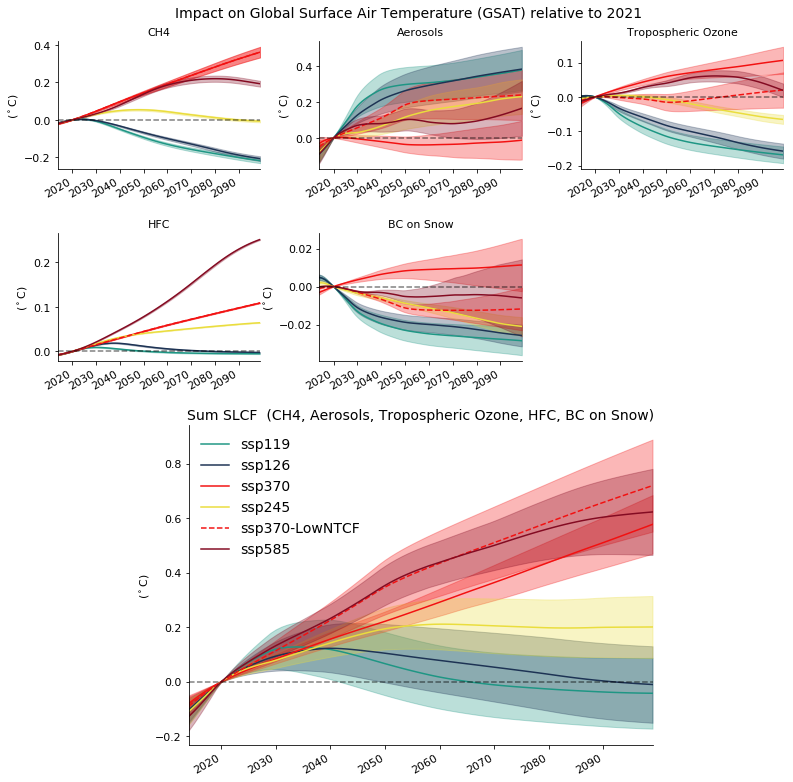

In [16]:
from ar6_ch6_rcmipfigs.utils.plot import trans_scen2plotlabel


#get_fig_ax_tot

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ar6_ch6_rcmipfigs.utils.misc_func import make_folders

figsize = [6, 4]
s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# scenario colors and linestyle
cdic = get_scenario_c_dic()
lsdic = get_scenario_ls_dic()#get_ls_dic(ds_DT[climatemodel].values)


SMALL_SIZE = 11
MEDIUM_SIZE = 11
BIGGER_SIZE = 16
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig2, axs, ax_tot = get_fig_ax_tot()#fig3 = plt.figure(constrained_layout=True)
_ds = ds_DT.sel(time=slice(s_y2, e_y2))
for var, ax in zip(variables_dt_comp, axs):

    print(var)

    #fig, ax = plt.subplots(1, 1, figsize=figsize)
    for scn in list(set(scenarios_fl) - {'historical'}):
        # compute difference from ref year:
        _da_ally = ds_DT[var].sel(scenario=scn, time=slice(s_y2, e_y2)) 
        _da_refy = ds_DT[var].sel(scenario=scn,time=slice(s_y, s_y)).squeeze()
        _da = _da_ally - _da_refy
        #_da = ds_DT[var].sel(scenario=scn, time=slice(s_y2, e_y2)) - ds_DT[new_varname(var, name_deltaT)].sel(
        #    scenario=scn,
        #    time=slice(s_y,
        #               s_y)).squeeze()
        # Compute mean: 
        _pl_da = _da.mean(climatemodel)
        # Plot mean: 
        _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle = lsdic[scn])
        # compute standard deviation:
        _std = _da.std(climatemodel)
        # plot +/- 1 standard deviation
        ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=0.3,
                        color=cdic[scn], label='_nolegen_')

    # various labels:
    ax.set_title('%s' % var.split('|')[-1])
    ax.set_ylabel('')
    ax.set_xlabel('')
    fix_ax(ax)
    # Plot zero line:
    ax.plot(_ds['time'], np.zeros(len(_ds['time'])), c='k', alpha=0.5, linestyle='dashed')
    
    
axs[0].set_ylabel('($^\circ$C)')
for ax in axs:
    #ax.set_ylabel('Change in temperature (C$^\circ$)')
    ax.set_ylabel('($^\circ$C)')
# Total:

SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ax = ax_tot

cdic = get_scenario_c_dic()
for var in [dt_totn]:  # , f_totn]:
    print(var)
    for scn in list(set(scenarios_fl) - {'historical'}):
        # Plot dataset difference to first year, i.e.
        ds_DT_sy = ds_DT[var].sel(scenario=scn,
                       time=slice(s_y, s_y)).squeeze()
        _da = ds_DT[var].sel(scenario=scn, time=slice(s_y2, e_y2)) - ds_DT_sy
        # Take mean over climate models:
        _pl_da = _da.mean(climatemodel)
        # Sum up the variables:
        _pl_da = _pl_da.sum(variable)
        # plot :
        _pl_da.plot(ax=ax, c=cdic[scn], label=trans_scen2plotlabel(scn), xticks=[], linestyle = lsdic[scn])
        # calculate standard deviation over the models:
        _std = _da.sum(variable).std(climatemodel)
        # Fill between +/- 1 std
        ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=0.3,
                        color=cdic[scn], label='_nolegend_')
_ds = ds_DT.sel(time=slice(s_y2, e_y2))
ax.plot(_ds['time'], np.zeros(len(_ds['time'])), c='k', alpha=0.5, linestyle='dashed')
plt.suptitle('Impact on Global Surface Air Temperature (GSAT) relative to 2021', fontsize=14)
# adjust plot visuals:
_str = ''
for var in ds_DT[variable].values: _str += '%s, ' % var.split('|')[-1]
#ax.set_title('Temperature change, sum SLCF  (%s)' % _str[:-2])
ax.set_title('Sum SLCF  (%s)' % _str[:-2])
#ax.set_ylabel('$\Delta$ T ($^\circ$C)')
ax.set_ylabel('($^\circ$C)')
ax.set_xlabel('')

ax.legend(frameon=False, loc=2)
fix_ax(ax)
plt.subplots_adjust(top=0.94, left=0.125, wspace=9.1, hspace=.5)
#plt.tight_layout()
plt.savefig(FIGURE_DIR+ '/total_ref2021_from2015_all_2.png', dpi=300)
plt.savefig(FIGURE_DIR+ '/total_ref2021_from2015_all_2.pdf')#, dpi=300)
plt.show()

Delta T|Anthropogenic|CH4


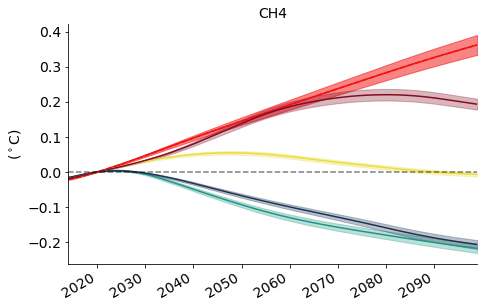

Delta T|Anthropogenic|Aerosols


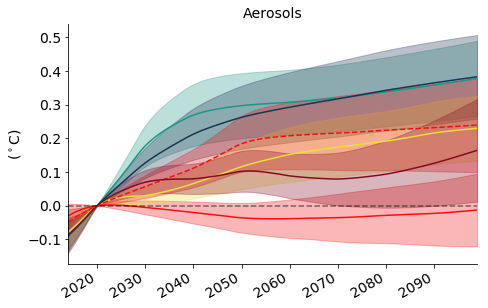

Delta T|Anthropogenic|Tropospheric Ozone


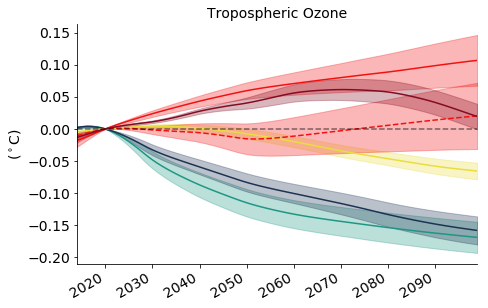

Delta T|Anthropogenic|F-Gases|HFC


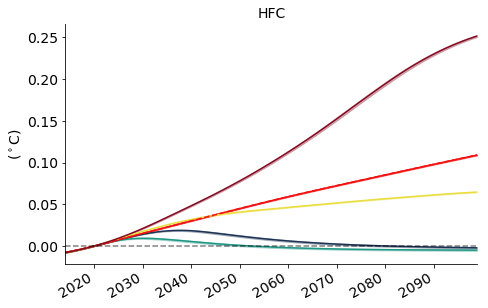

Delta T|Anthropogenic|Other|BC on Snow


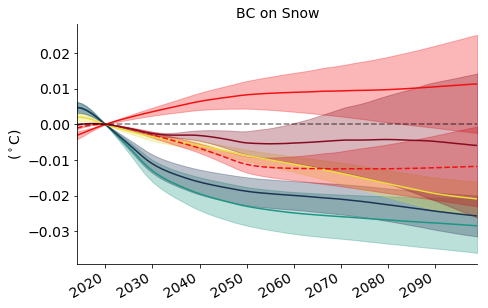

Delta T|Anthropogenic|All


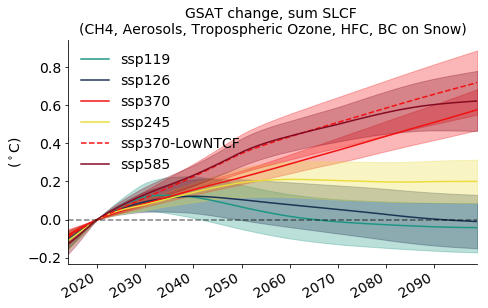

In [17]:

figsize = [7, 4.5]
s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# Get linestyle and colormap for scenarios:
lsdic = get_scenario_ls_dic()#
cdic = get_scenario_c_dic()


for var in variables_dt_comp:
    print(var)

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for scn in list(set(scenarios_fl) - {'historical'}): # skip historical scenario
        first = True
        # compute difference from ref year:
        _da_ally = ds_DT[var].sel(scenario=scn, time=slice(s_y2, e_y2)) 
        _da_refy = ds_DT[var].sel(scenario=scn,time=slice(s_y, s_y)).squeeze()
        _da = _da_ally - _da_refy
        #_da = ds_DT[var].sel(scenario=scn, time=slice(s_y2, e_y2)) - ds_DT[new_varname(var, name_deltaT)].sel(
        #    scenario=scn,
        #    time=slice(s_y,
        #               s_y)).squeeze()
        # Compute mean: 
        _pl_da = _da.mean(climatemodel)
        # Plot mean: 
        _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle = lsdic[scn])
        # compute standard deviation:
        _std = _da.std(climatemodel)
        # plot +/- 1 standard deviation
        ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=0.3,
                        color=cdic[scn], label='_nolegen_')
    # various labeling
    ax.set_title('%s' % var.split('|')[-1])
    ax.set_ylabel('($^\circ$C)')
    ax.set_xlabel('')
    # figname
    fign = FIGURE_DIR +fign_dt(var, s_y, s_y2)
    make_folders(fign)
    fix_ax(ax)
    # plot zero line:
    _ds = ds_DT.sel(time=slice(s_y2, e_y2))
    ax.plot(_ds['time'], np.zeros(len(_ds['time'])), c='k', alpha=0.5, linestyle='dashed')

    plt.tight_layout()
    plt.savefig(fign, dpi=300)
    plt.savefig(fign[:-3]+'pdf')#, dpi=200)
    plt.show()

# Total:
fig, ax = plt.subplots(1, 1, figsize=figsize)  # [9,5])

for var in [dt_totn]:  # , f_totn]:
    print(var)
    for scn in list(set(scenarios_fl) - {'historical'}):
        # Plot dataset difference to first year, i.e.
        ds_DT_sy = ds_DT[var].sel(scenario=scn,
                       time=slice(s_y, s_y)).squeeze()
        _da = ds_DT[var].sel(scenario=scn, time=slice(s_y2, e_y2)) - ds_DT_sy
        # Take mean over climate models:
        _pl_da = _da.mean(climatemodel)
        # Sum up the variables:
        _pl_da = _pl_da.sum(variable)
        # plot :
        _pl_da.plot(ax=ax, c=cdic[scn], label=trans_scen2plotlabel(scn), xticks=[], linestyle = lsdic[scn])
        # calculate standard deviation over the models:
        _std = _da.sum(variable).std(climatemodel)
        # Fill between +/- 1 std
        ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=0.3,
                        color=cdic[scn], label='_nolegend_')

# adjust plot visuals:
_str = ''
for var in ds_DT[variable].values: _str += '%s, ' % var.split('|')[-1]
ax.set_title('GSAT change, sum SLCF \n(%s)' % _str[:-2])

ax.set_ylabel('($^\circ$C)')
ax.set_xlabel('')

ax.legend(frameon=False, loc=2)
fix_ax(ax)
_ds = ds_DT.sel(time=slice(s_y2, e_y2))
ax.plot(_ds['time'], np.zeros(len(_ds['time'])), c='k', alpha=0.5, linestyle='dashed')

plt.tight_layout()
plt.savefig(FIGURE_DIR + fign_dt('total', s_y,s_y2 ), dpi=200)
plt.savefig(FIGURE_DIR + fign_dt('total', s_y,s_y2 )[:-3]+'pdf', dpi=200)
plt.show()

# Supplementary plots:

## Plot $\Delta$ T and ERF with reference year +/- 1 standard deviation of the models

Effective Radiative Forcing|Anthropogenic|CH4


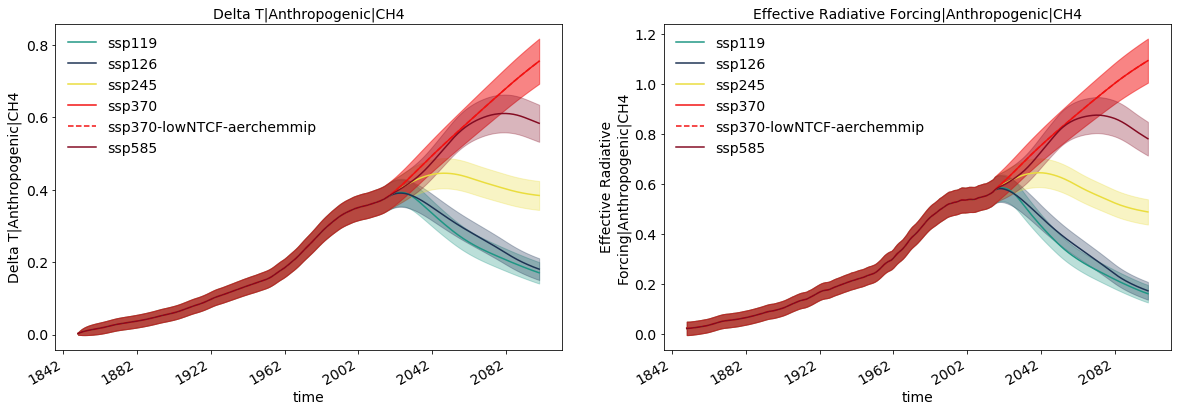

Effective Radiative Forcing|Anthropogenic|Aerosols


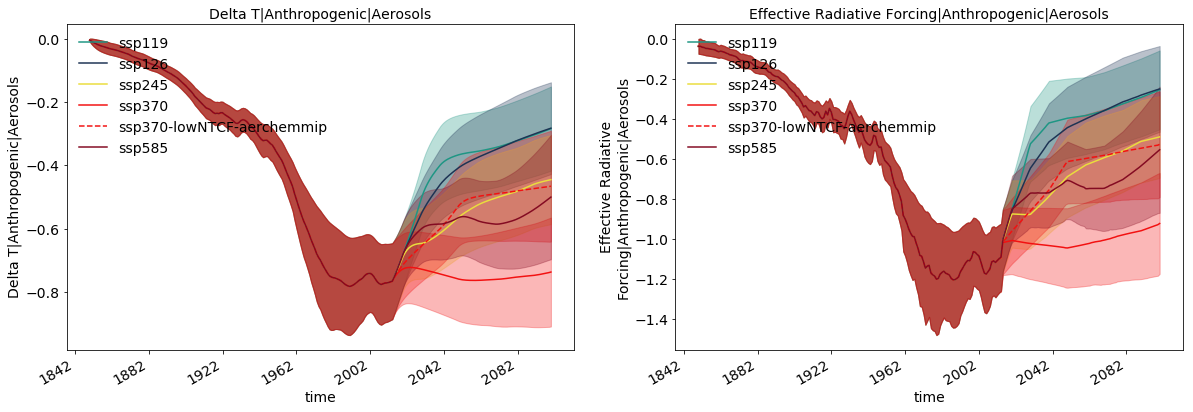

Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone


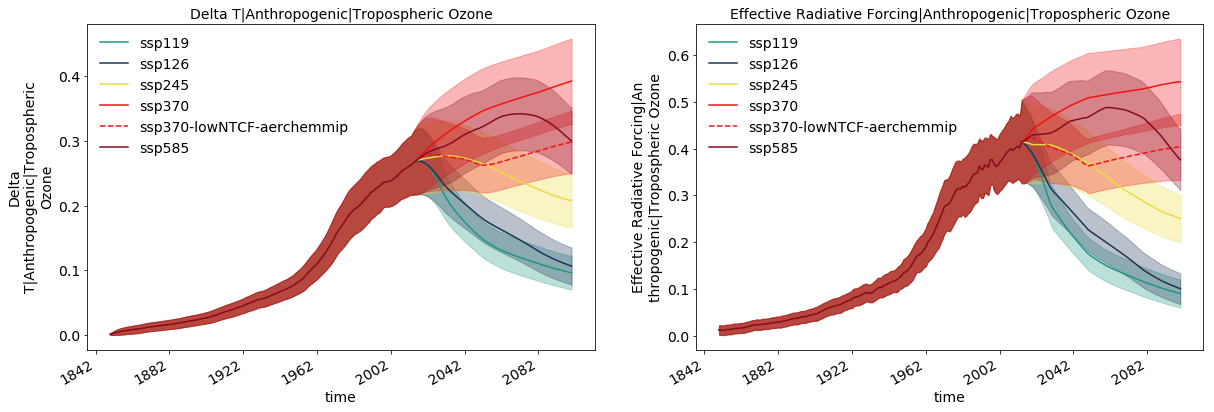

Effective Radiative Forcing|Anthropogenic|F-Gases|HFC


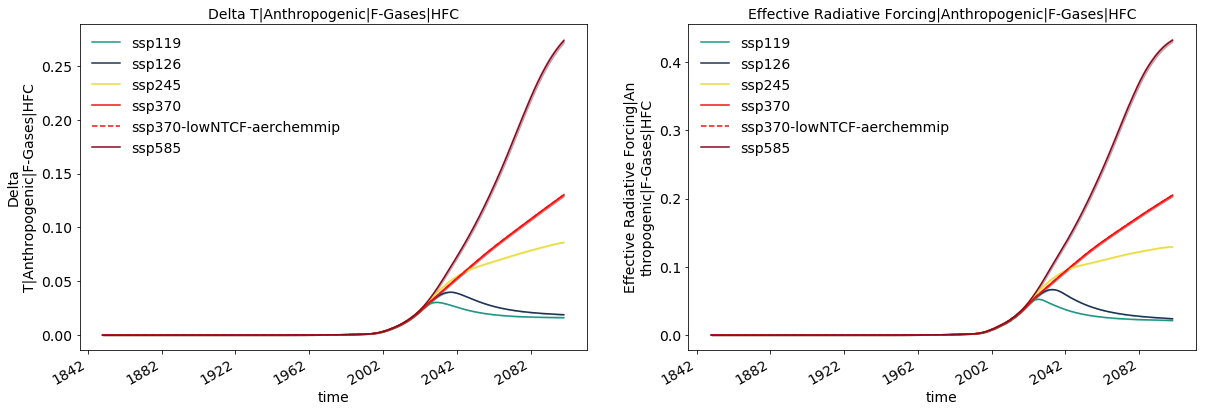

Effective Radiative Forcing|Anthropogenic|Other|BC on Snow


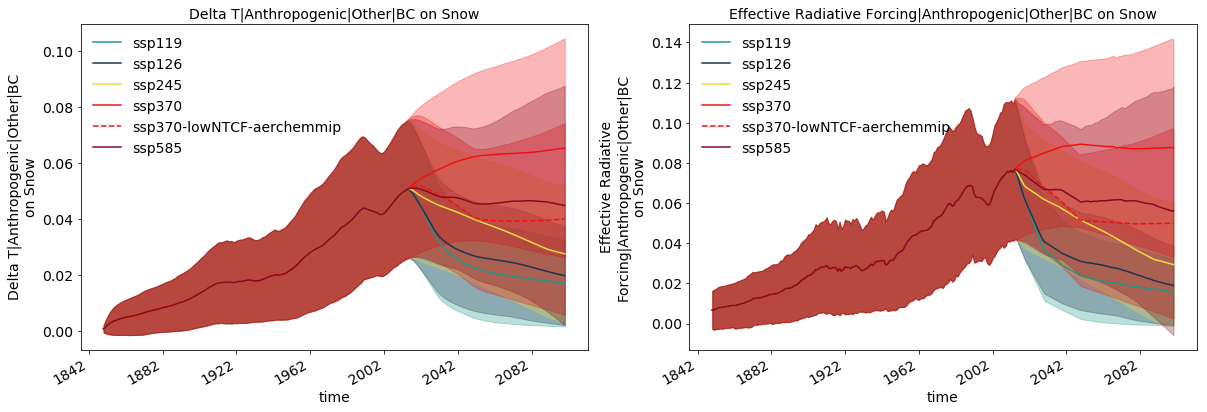

In [18]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_ls_dic, get_scenario_c_dic

# Get linestyle scenarios:
lsdic = get_scenario_ls_dic()#get_ls_dic(ds_DT[climatemodel].values)
s_y = '2021'
e_y = '2100'
# Get colorscheme scenarios
cdic = get_scenario_c_dic()
alpha = 0.3
for var in variables_erf_comp:
    fig, axs = plt.subplots(1, 2, figsize=[20, 6])
    for scn in scenarios_fl:#) - {'historical'}):
        first = True
        _da1 = ds_DT[new_varname(var, name_deltaT)].sel(scenario=scn)        
        _da2 = ds_DT[var].sel(scenario=scn)
        for _da, ax in zip([_da1, _da2], axs):
            _pl_da = _da.mean(climatemodel)
            _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle = lsdic[scn])
            _std = _da.std(climatemodel)
            # fill between +/z 1 std
            ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=alpha,
                            color=cdic[scn], label='_nolegen_')
    print(var)

    axs[0].set_title(new_varname(var, name_deltaT))
    axs[1].set_title(var)
    # axs[1].set_title('%s'%( ('|'.join(var.split('|')[1:]))))

    axs[0].legend(frameon=False, loc=2)
    axs[1].legend(frameon=False, loc=2)

    plt.show()

Effective Radiative Forcing|Anthropogenic|CH4


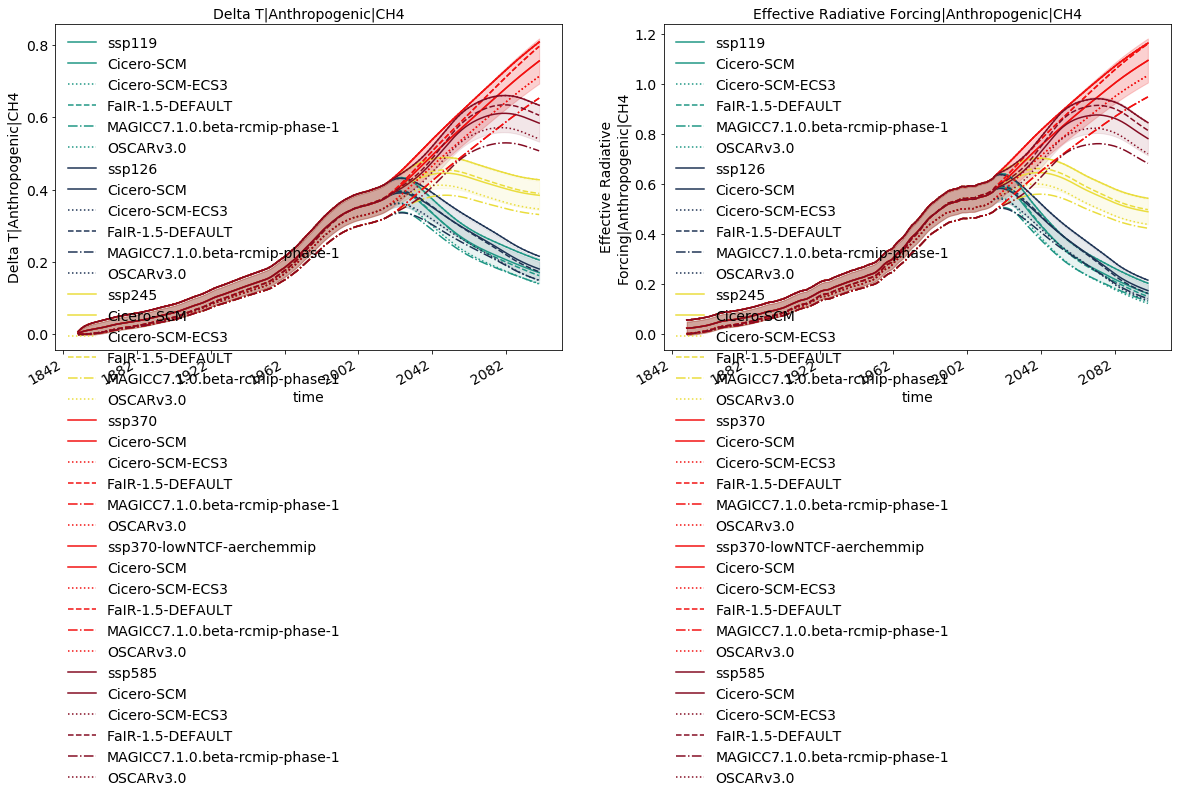

Effective Radiative Forcing|Anthropogenic|Aerosols


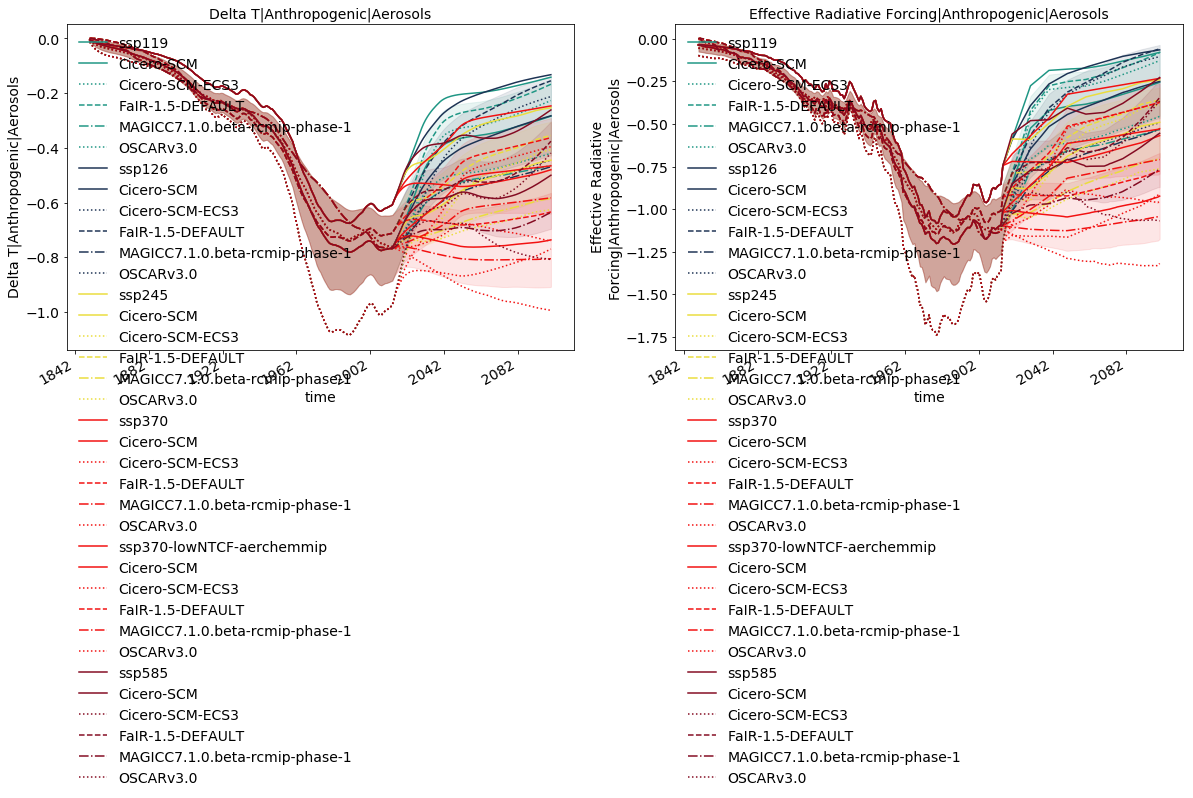

Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone


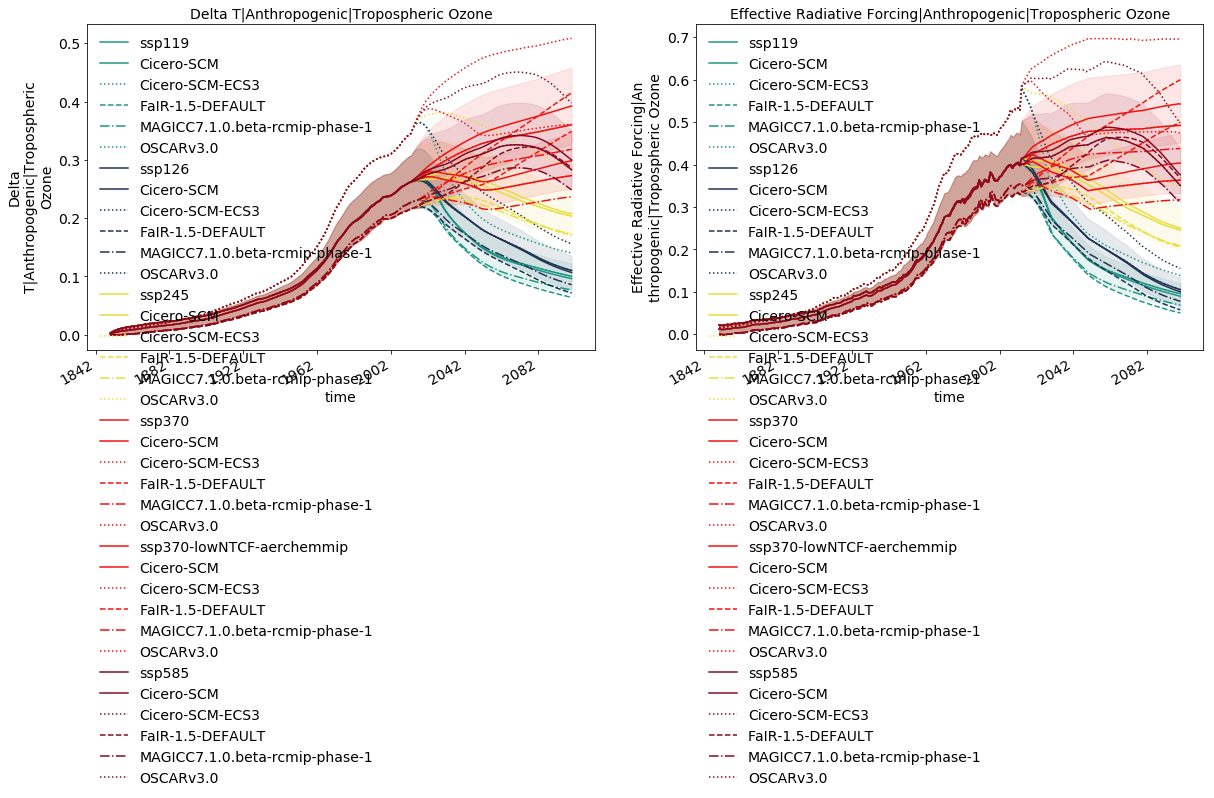

Effective Radiative Forcing|Anthropogenic|F-Gases|HFC


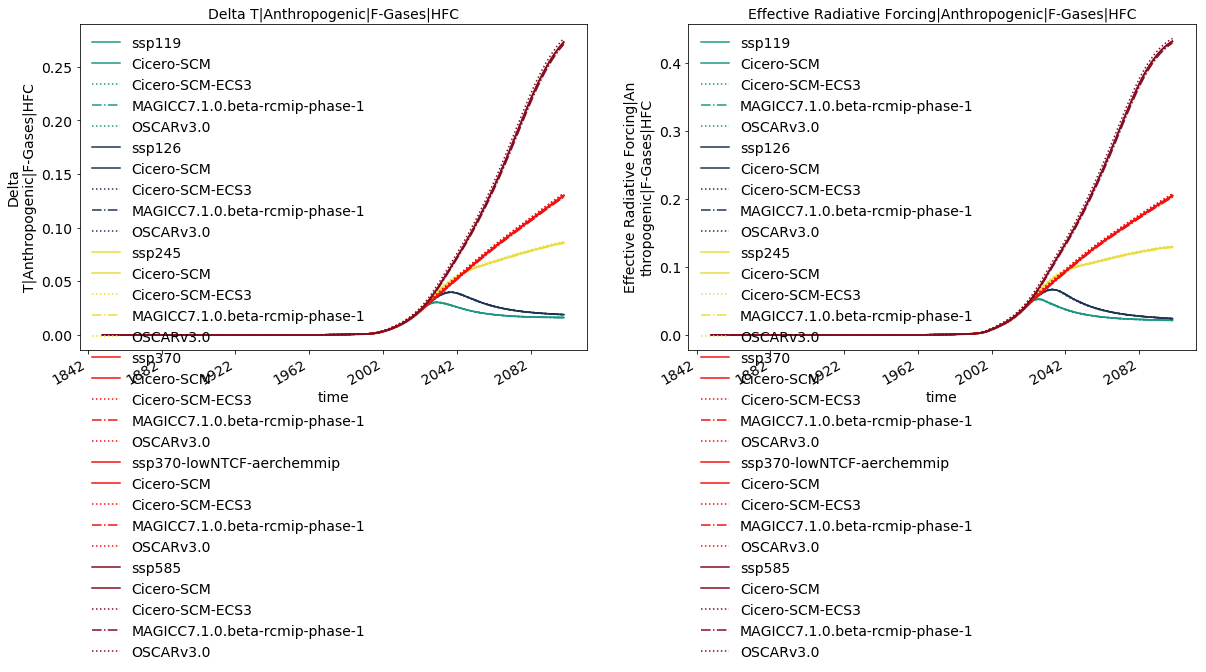

Effective Radiative Forcing|Anthropogenic|Other|BC on Snow


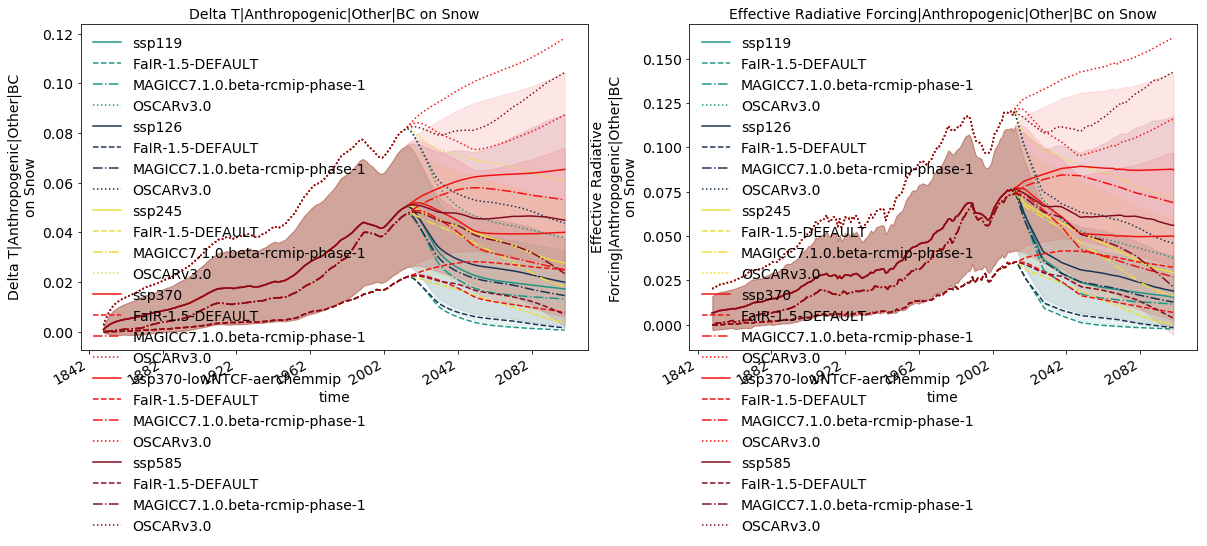

In [19]:
from ar6_ch6_rcmipfigs.utils.plot import get_ls_dic
lsdic = get_ls_dic(ds_DT[climatemodel].values)
s_y = '2021'
e_y = '2100'
cdic = get_scenario_c_dic()
ls_dic = get_ls_dic(climatemodels_fl)
ls_dic[climatemodels_fl[-1]] = 'dotted'
for var in variables_erf_comp:
    fig, axs = plt.subplots(1, 2, figsize=[20, 6])
    for scn in scenarios_fl:#list(set(scenarios) - {'historical'}):
        first = True
        _da1 = ds_DT[new_varname(var, name_deltaT)].sel(scenario=scn)        
        _da2 = ds_DT[var].sel(scenario=scn)
        for _da, ax in zip([_da1, _da2], axs):
            _pl_da = _da.mean(climatemodel)
            _pl_da.plot(ax=ax, c=cdic[scn], label=scn)
            _std = _da.std(climatemodel)
            ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=0.1,
                            color=cdic[scn], label='_nolegen_')
            for cm in _da[climatemodel].values:
                if not np.all(_da.sel(climatemodel=cm).isnull()):
                    _da.sel(climatemodel=cm).plot(ax=ax,linestyle=ls_dic[cm], color=cdic[scn], label=cm)
    print(var)

    axs[0].set_title(new_varname(var, name_deltaT))
    axs[1].set_title(var)
    # axs[1].set_title('%s'%( ('|'.join(var.split('|')[1:]))))

    axs[0].legend(frameon=False, loc=2)
    axs[1].legend(frameon=False, loc=2)

    plt.show()

Subtracting year 2021, while still plotting from 2015. Thus the results represent the cooling/warming with respect to year 2021

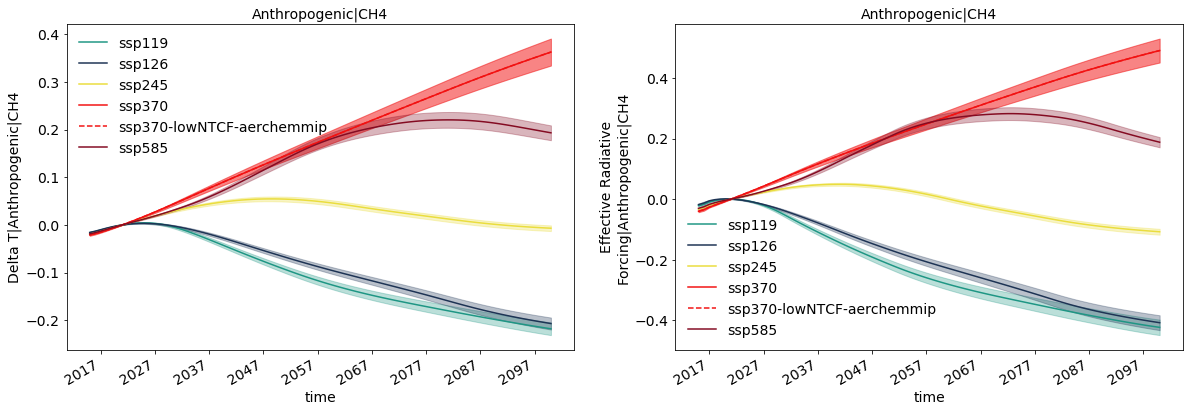

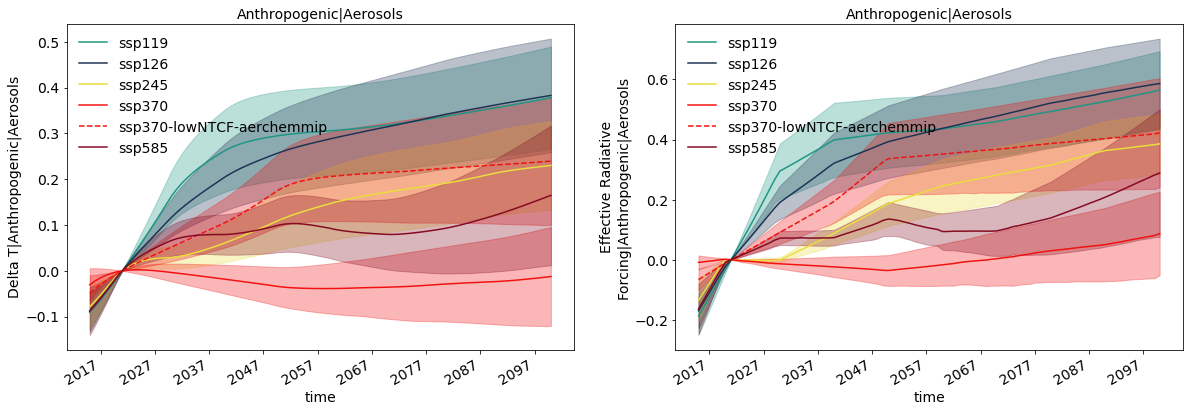

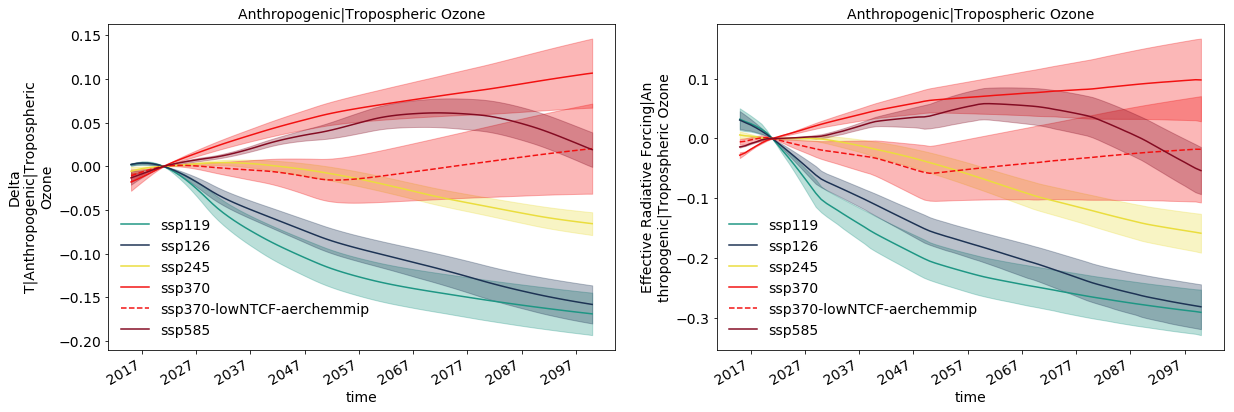

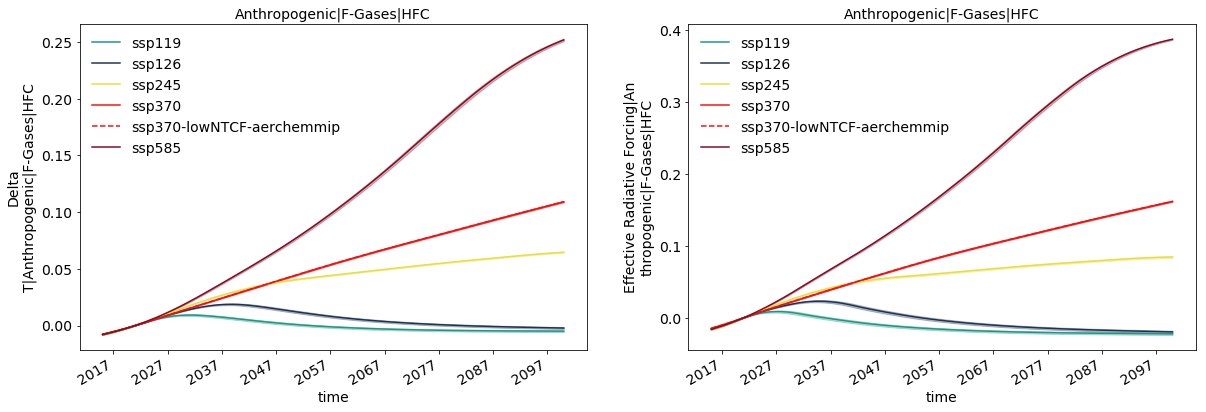

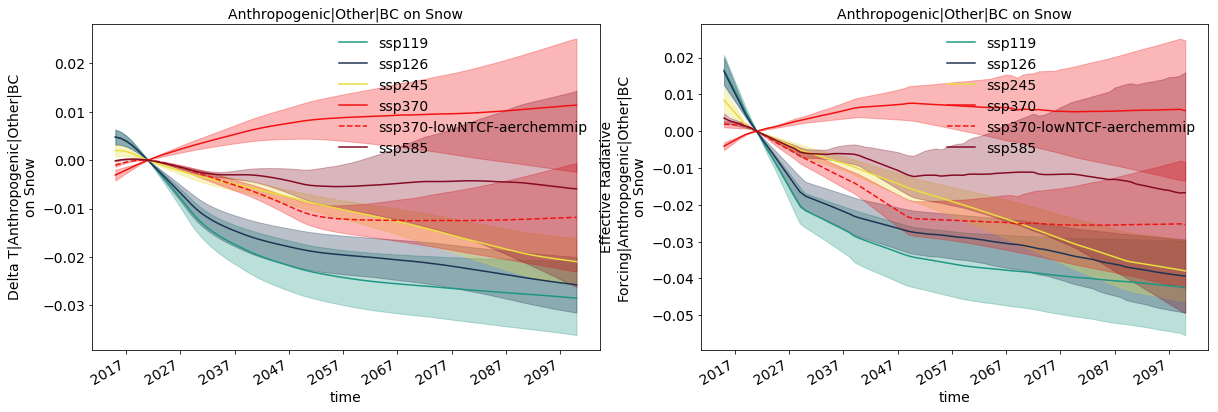

In [20]:

cdic = get_scenario_c_dic()# get_cmap_dic(ds_DT[scenario].values)
lsdic = get_scenario_ls_dic()# _scget_ls_dic(ds_DT[climatemodel].values)
s_y = '2021'
e_y = '2100'
s_y2 = '2015'
e_y2 = '2100'
cdic = get_scenario_c_dic()

for var in variables_erf_comp:
    fig, axs = plt.subplots(1, 2, figsize=[20, 6])
    for scn in scenarios_fl:#list(set(scenarios) - {'historical'}):
        first = True
        _da1 = ds_DT[new_varname(var, name_deltaT)].sel(scenario=scn, time=slice(s_y2, e_y2)) - ds_DT[
            new_varname(var, name_deltaT)].sel(
            scenario=scn, time=slice(s_y, s_y)).squeeze()
        _da2 = ds_DT[var].sel(scenario=scn, time=slice(s_y2, e_y2)) - ds_DT[var].sel(scenario=scn,
                                                                                     time=slice(s_y, s_y)).squeeze()
        for _da, ax in zip([_da1, _da2], axs):
            _pl_da = _da.mean(climatemodel)
            _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle = lsdic[scn])
            _std = _da.std(climatemodel)
            ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=0.3,
                            color=cdic[scn], label='_nolegen_')
    axs[0].set_title('%s' % (('|'.join(var.split('|')[1:]))))
    axs[1].set_title('%s' % (('|'.join(var.split('|')[1:]))))

    axs[0].legend(frameon=False)  # , loc=2)
    axs[1].legend(frameon=False)  # , loc=2)

    plt.show()